In [1]:
!pip install poetry

  Using cached poetry-2.1.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached cachecontrol-0.14.2-py3-none-any.whl.metadata (3.1 kB)
  Using cached cleo-2.1.0-py3-none-any.whl.metadata (12 kB)
  Using cached dulwich-0.22.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (4.9 kB)
  Using cached findpython-0.6.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached installer-0.7.0-py3-none-any.whl.metadata (936 bytes)
  Using cached keyring-25.6.0-py3-none-any.whl.metadata (20 kB)
  Using cached pbs_installer-2025.3.17-py3-none-any.whl.metadata (991 bytes)
  Using cached pkginfo-1.12.1.2-py3-none-any.whl.metadata (13 kB)
  Using cached poetry_core-2.1.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached pyproject_hooks-1.2.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached tomlkit-0.

In [2]:
!poetry add pymilvus llama_index ftfy regex tqdm 
!poetry add transformers
!poetry add llama-index-vector-stores-milvus llama-index-llms-ollama llama-index-embeddings-huggingface
!poetry add git+https://github.com/openai/CLIP.git
!poetry add torch torchvision
!poetry add matplotlib scikit-image
!poetry add wikipedia

The following packages are already present in the pyproject.toml and will be skipped:

  - pymilvus
  - llama_index
  - ftfy
  - regex
  - tqdm

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.
The following packages are already present in the pyproject.toml and will be skipped:

  - transformers

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.
The following packages are already present in the pyproject.toml and will be skipped:

  - llama-index-vector-stores-milvus
  - llama-index-llms-ollama
  - llama-index-embeddings-huggingface

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to t

# Download articles from wikipedia 


![](./wiki-to-text.png)

In [3]:
wiki_titles = ["Helsinki", "iPhone", "The Sopranos", "GIC", "Vietnam"]

In [ ]:
from pathlib import Path
import requests

data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

# Let's convert our text into vectors

![](./text-to-embeddings.png)

In [7]:
from pymilvus import MilvusClient

from llama_index.core import (
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.vector_stores.milvus import MilvusVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.llms.ollama import Ollama

text_client = MilvusClient()
text_documents = SimpleDirectoryReader("./data_wiki").load_data()

service_context = ServiceContext.from_defaults(
    llm=Ollama(model="llama3", request_timeout=120.0, temperature=0.1),
    embed_model="local:BAAI/bge-base-en-v1.5",
)

text_vector_store = MilvusVectorStore(
    client=text_client, collection_name="wikipedia_text", dim=768, overwrite=True
)

storage_context = StorageContext.from_defaults(vector_store=text_vector_store)

wiki_text_index = VectorStoreIndex.from_documents(
    text_documents, storage_context=storage_context, service_context=service_context
)

text_query_engine = wiki_text_index.as_query_engine()

/var/folders/zh/4h5q6_5x0sx87fvsgc4_gdpm0000gn/T/ipykernel_43785/3242720480.py:14: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


# Download images from wikipedia
![](wiki-to-images.png)

In [11]:
import wikipedia
import urllib.request

image_path = Path("images_wiki")
image_uuid = 0

image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 20


if not image_path.exists():
    Path.mkdir(image_path)

# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(url, image_path / f"{image_uuid}.jpg")
                images_per_wiki += 1
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        continue

Helsinki
iPhone
The Sopranos
GIC


/Users/ivantang/anaconda3/envs/multimodal/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/ivantang/anaconda3/envs/multimodal/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Vietnam


# Let's preview our images 

/Users/ivantang/anaconda3/envs/multimodal/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


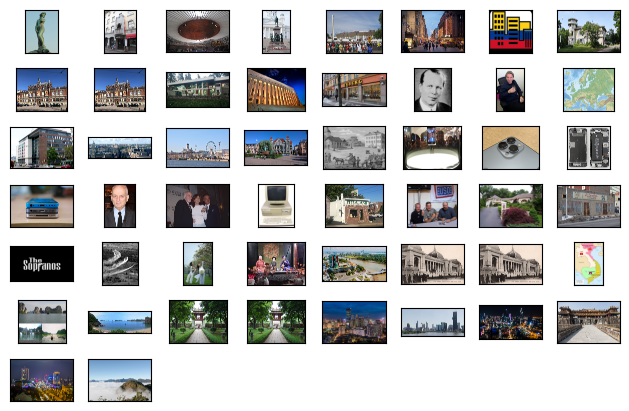

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

# Let's convert images to embeddings

![](./images-to-embeddings.png)

In [12]:
import torch
import clip
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model, preprocess = clip.load("ViT-B/32", device=device)

img_emb_dict = {}
with torch.no_grad():
    for image_id in image_metadata_dict:
        img_file_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_file_path):
            image = (
                # preprocess the image using the CLIP model's preprocess function
                # unsqueeze the image tensor to add a batch dimension
                # move the image tensor to the device specified in line 2
                preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
            )
            image_features = model.encode_image(image)
            img_emb_dict[image_id] = image_features

cpu


In [13]:
from llama_index.core.schema import ImageDocument

img_documents = []
for image_filename in image_metadata_dict:
    if image_filename in img_emb_dict:
        filename = image_metadata_dict[image_filename]["filename"]
        filepath = image_metadata_dict[image_filename]["img_path"]

        newImgDoc = ImageDocument(text=filename, metadata={"filepath": filepath})

        newImgDoc.embedding = img_emb_dict[image_filename].tolist()[0]
        img_documents.append(newImgDoc)

image_vector_store = MilvusVectorStore(
    client=text_client, collection_name="wikipedia_img", dim=512, overwrite=True
)

storage_context = StorageContext.from_defaults(vector_store=image_vector_store)

image_index = VectorStoreIndex.from_documents(
    img_documents, storage_context=storage_context, service_context=service_context
)

In [14]:
from llama_index.core.vector_stores import VectorStoreQuery


def retrieve_results_from_image_index(query):
    """take a text query as input and return the most similar image from the vector store"""

    text = clip.tokenize(query).to(device)

    query_embedding = model.encode_text(text).tolist()[0]

    image_vector_store_query = VectorStoreQuery(
        query_embedding=query_embedding,
        similarity_top_k=1,  # returns 1 image
        mode="default",
    )

    image_retrieval_results = image_vector_store.query(image_vector_store_query)
    return image_retrieval_results

In [15]:
def plot_image_retrieve_results(image_retrieval_results):
    """take a list of image retrieval results and create a new figure"""

    plt.figure(figsize=(16, 5))

    img_cnt = 0

    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

In [16]:
def image_query(query):
    image_retrieval_results = retrieve_results_from_image_index(query)
    plot_image_retrieve_results(image_retrieval_results)

# The moment of truth...
![](./truth.gif)

Text retrieval results: 
The iPhone is a line of smartphones developed and marketed by Apple that run iOS, the company's own mobile operating system. The first-generation iPhone was announced by then–Apple CEO and co-founder Steve Jobs on January 9, 2007, at Macworld 2007, and launched later that year. Since then, Apple has annually released new iPhone models and iOS versions; the most recent models being the iPhone 16 and 16 Plus, alongside the higher-end iPhone 16 Pro and 16 Pro Max, and the lower-end iPhone 16e.


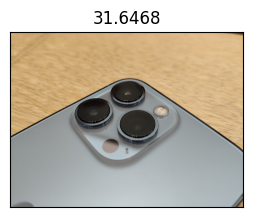

In [21]:
# https://en.wikipedia.org/wiki/iPhone
query1 = "Can you tell me more about the iPhone?"

image_query(query1)

text_retrieval_results = text_query_engine.query(query1)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
Some popular tourist attractions in Vietnam include the former Imperial City of Huế, the World Heritage Sites of Phong Nha – Kẻ Bàng National Park, Hội An and Mỹ Sơn, coastal regions such as Nha Trang, the caves of Hạ Long Bay, and the Marble Mountains.


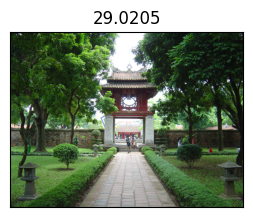

In [20]:
# https://en.wikipedia.org/wiki/Helsinki
query2 = "What are some of the popular tourist attraction in Vietnam?"
image_query(query2)

text_retrieval_results = text_query_engine.query(query2)
print("Text retrieval results: \n" + str(text_retrieval_results))